In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline

import Conversion

import warnings
warnings.filterwarnings('ignore')

wd = '/Users/ewenwang/Documents/practice_data/conversion_rate/'

In [ ]:
file = 'data_all.txt'
Data = Conversion.Data(wd=wd, data_list=[file])

In [ ]:
pp.ProfileReport(Data.all_data)

In [ ]:
d = [18, 21, 19, 20, 22, 23, 24, 25]

vd_list = [23, 24]

dtrain = Data.all_data.loc[Data.all_data.day < np.array(vd_list).min()]
dvalidation = Data.all_data.loc[Data.all_data.day.isin(vd_list)]

print(dtrain.day.unique(), dvalidation.day.unique())

In [ ]:
def Validation(validation_day=[24]):                                # array([18, 21, 19, 20, 22, 23, 24, 25])
    """Generate training and validation sets."""
    dtrain = Data.all_data.loc[Data.all_data.day < np.array(validation_day).min()]
    dvalidation = Data.all_data.loc[Data.all_data.day.isin(validation_day)]
    
    return dtrain, dvalidation

In [ ]:
dtrain, dvalidation = Validation(validation_day=[24])
print(dtrain.day.unique(), dvalidation.day.unique())

In [ ]:
categorical_features = ['item_id', 'item_brand_id', 'item_city_id', 
'user_id', 'user_gender_id', 'user_occupation_id', 
'context_id', 'context_page_id', 
'shop_id', 
'category_1', 'category_2', 'property_0', 'property_1', 'property_2', 
'predict_category_0', 'predict_category_1', 'predict_category_2']

In [ ]:
def featureEng(all_data, train, feature):
    """Feature engineering for preprocessed data."""
    feature_df = pd.DataFrame(all_data.groupby([feature], as_index=False).size().reset_index())
    feature_df.rename(columns={0:feature+'_count'}, inplace=True)

    feature_clk_df = pd.DataFrame(train.groupby([feature], as_index=False).size().reset_index())
    feature_clk_df.rename(columns={0:feature+'_count'}, inplace=True)

    feature_cv_df = pd.DataFrame(train[(train.is_trade==1)].groupby([feature], as_index=False).size().reset_index())
    feature_cv_df.rename(columns={0:feature+'_trade_count'}, inplace=True)

    feature_cvr_df = feature_clk_df.merge(feature_cv_df, on=feature, how='left')
    feature_cvr_df[feature+'_cvr'] = feature_cvr_df[feature+'_trade_count']/feature_cvr_df[feature+'_count']

    feature_df = feature_df.merge(feature_cvr_df, on=feature, how='left')

    feature_df[feature+'_count_change'] = feature_df[feature+'_count_x']-feature_df[feature+'_count_y']
    feature_df[feature+'_count_change_pct'] = feature_df[feature+'_count_change']/feature_df[feature+'_count_y']

    return feature_df

In [ ]:
def ValidationFE(validation_day=[24]):                                # array([18, 21, 19, 20, 22, 23, 24, 25])
    """Generate training and validation sets and do feature enginerring."""
    dtrain = Data.all_data.loc[Data.all_data.day < np.array(validation_day).min()]
    dvalidation = Data.all_data.loc[Data.all_data.day.isin(validation_day)]
    dall = dtrain.append(dvalidation)

    for feature in categorical_features:
        dtrain = dtrain.merge(featureEng(all_data=dall, train=dtrain, feature=feature), on=feature, how='left')
        dvalidation = dvalidation.merge(featureEng(all_data=dall, train=dtrain, feature=feature), on=feature, how='left')
        
    return dtrain, dvalidation

In [ ]:
dtrain, dvalidation = Data.ValidationFE()
print(dtrain.shape, dvalidation.shape)

In [ ]:
pp.ProfileReport(dvalidation)

In [ ]:
cv = 3
cross_valid_1 = KFold(cv).split(dtrain[Data.predictors])
cross_valid_2 = KFold(cv).split(dvalidation[Data.predictors])

for train_index, _ in cross_valid_1:
    X_train = dtrain[Data.predictors].loc[train_index,:]
    y_train = dvalidation[Data.predictors][train_index]

    for _, test_index in cross_valid_2:
        X_test = _, dvalidation[Data.predictors].loc[test_index,:]
        y_test = _, dvalidation[Data.target][test_index]
        
        est = clone(self.__est)
        est.fit(X_train, y_train)
        k_score = scorer(est, X_test, y_test)
        scores.append(k_score)

In [ ]:
Data.Save(dtrain, '24_train.txt')
Data.Save(dvalidation, '24_validation.txt')

## Training

In [2]:
v24_data = ['24_train.txt', '24_validation.txt']

Data = Conversion.Data(wd, v24_data, is_all=False)
dtrain, dvalidation = Data.train, Data.test

In [3]:
Algorithm = Conversion.Algorithm(dtrain=dtrain, dvalidation=dvalidation, target=Data.target, features=Data.predictors)

In [4]:
clf_bsline = Algorithm.Baseline()

Start training...
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.0856175
log loss:  0.08561745311372007


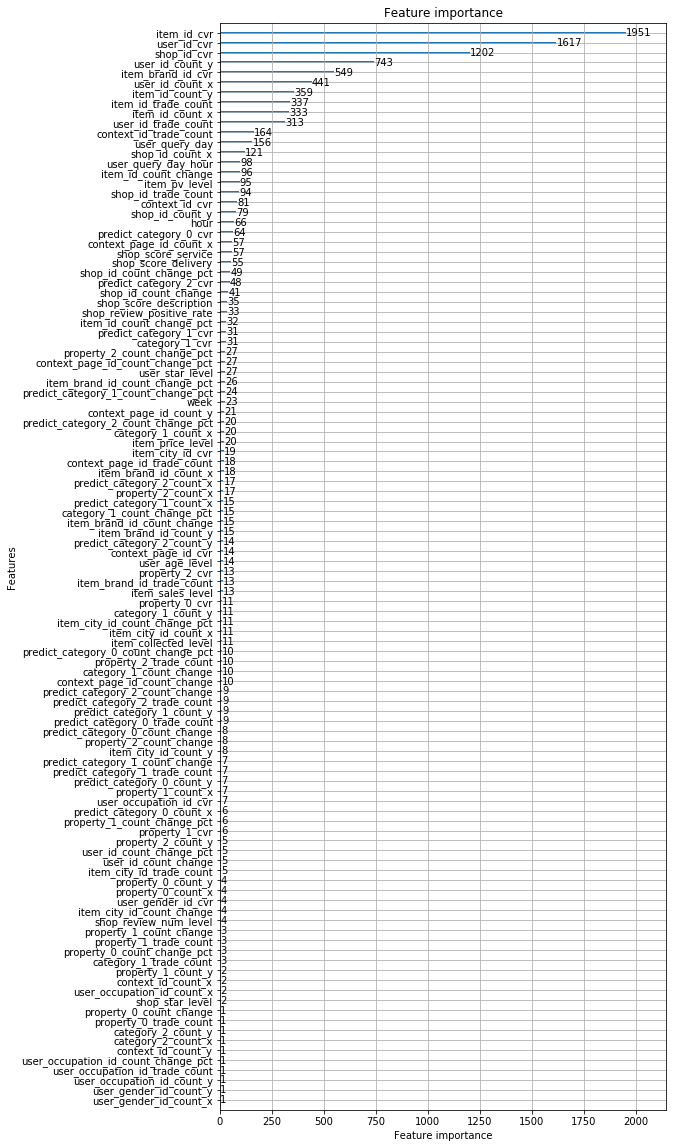

In [5]:
lgb.plot_importance(clf_bsline, figsize=(8, 20))

In [7]:
# clf_sim_1 = Algorithm.simAnneal(alpha=0.75, n_trans=5, scoring='neg_log_loss')

In [ ]:
clf_sim_2 = Algorithm.simAnneal(alpha=0.75, n_trans=10, scoring='neg_log_loss')

In [ ]:
clf_sim_3 = Algorithm.simAnneal(alpha=0.85, n_trans=10, scoring='neg_log_loss')